## <font color='Blue'>Introduction</font>
###  In the practical, we run the example model for evaluation of permebaility field.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


In [2]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import numpy as np
import matplotlib.pyplot as plt

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [39]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 60, db = 8):
        # nd = size of the block 
        # db = size of the model assuming that the dx=dy
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)
        
        # injector in the center 
        self.ix = np.int32(self.nx / 3 *2)
        self.iy = np.int32(self.ny / 3 *2)
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)
        
        # producer in the last block 
        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.ny, 1, well_index=0.5)
        
        self.reservoir.add_well("PRD2") # top left corner 
        self.reservoir.add_perforation(self.reservoir.wells[-1], 1, self.iy, 1, well_index=50)
        
        self.reservoir.add_well("PRD3") # bottom left corner 
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, 1, 1, well_index=10)
        
        self.reservoir.add_well("PRD4") # bottom right corner 
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.nx, self.iy, 1, well_index=0.5)
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 5000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny) # reshape pressure to a matrix 
        kx = self.permx.reshape(self.ny, self.nx) 
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1) # reduced dimension which is required for the streamlines computations 

        v = np.zeros((nvx, nvy)) # velocity in the x direction
        u = np.zeros((nvx, nvy)) # velocity in the y direction 
        ir, jr = (range(nvx), range(nvy))

        for i in ir: # no need to use transmissibility because all the blocks are the same 
            # average permaeability between block i and i+1
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            # average permaeability between block j and j+1
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

<img style="float: left;" src="slides/Slide7.JPG" width="80%">

In [5]:
# loading permeability
perm = load_single_keyword('data.in','PERMX') #specify the name of the file and the k word
# define the model
m = Model(perm)
m.init()
m.run()
print("Simulation finished")

Reading PERMX from /home/jovyan/data.in... 3600 values have been read.
darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


<img style="float: left;" src="slides/Slide8.JPG" width="80%">

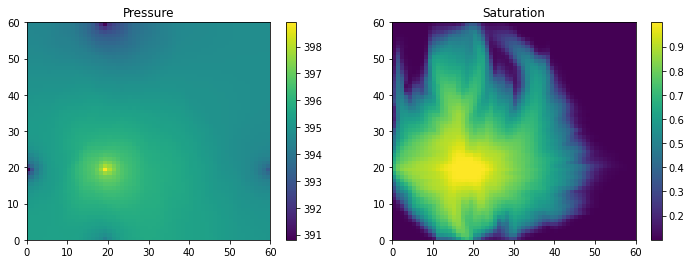

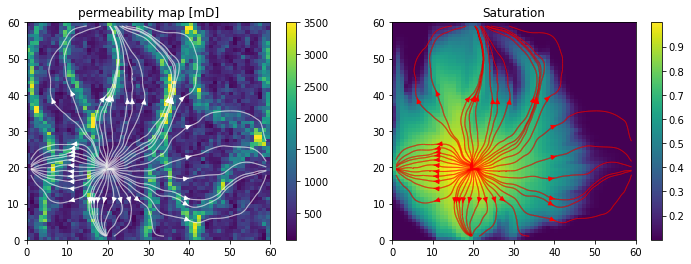

In [6]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('permeability map [mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide9.JPG" width="80%">

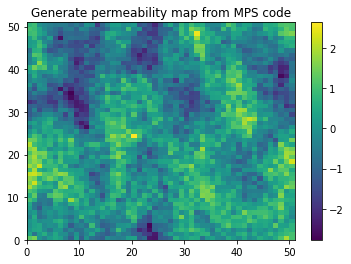

In [7]:
from scipy.io import loadmat 
data = loadmat('model_1.mat')
realiz = np.array(data['realz'])

plt.figure()
plt.pcolor(realiz)
plt.colorbar()
plt.title('Generate permeability map from MPS code')
plt.show()

<img style="float: left;" src="slides/Slide10.JPG" width="80%">

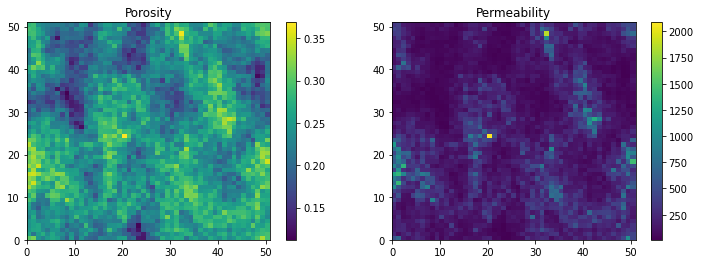

(51, 51)

In [8]:
m = 0.24
mr = np.mean(realiz)
sigma = 0.04
sigmar = np.std(realiz)

phi = m-mr*sigma/sigmar+realiz*sigma/sigmar

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.title('Porosity')
plt.colorbar()

perm = 10**(9*phi)

# plot solution
plt.subplot(122)
plt.pcolor(perm)
plt.title('Permeability')
plt.colorbar()
plt.show()

np.shape(perm)


<img style="float: left;" src="slides/Slide11.JPG" width="80%">

In [9]:
m = Model(perm,51)
m.init()
m.run()
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


In [1]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,col='w')
plt.colorbar()
plt.title('permeability map [mD]')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()


plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,phi,col='w')
plt.colorbar()
plt.title('porosity map [mD]')

NameError: name 'np' is not defined

<img style="float: left;" src="slides/Slide12.JPG" width="80%">

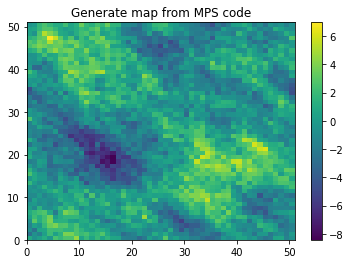

In [40]:
from scipy.io import loadmat 
data = loadmat('FEMKE_MODEL.mat')
realiz = np.array(data['realz'])

plt.figure()
plt.pcolor(realiz)
plt.colorbar()
plt.title('Generate map from MPS code')
plt.show()

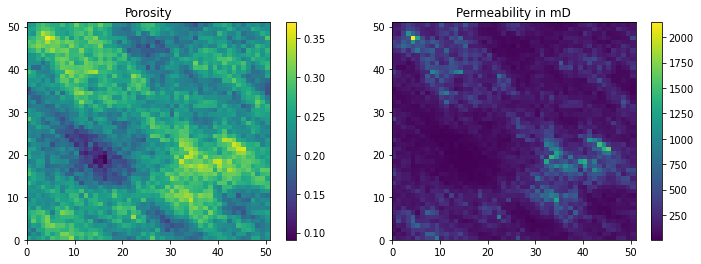

(51, 51)

In [41]:
m = 0.24
mr = np.mean(realiz)
sigma = 0.04
sigmar = np.std(realiz)

phi = m-mr*sigma/sigmar+realiz*sigma/sigmar

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(phi)
plt.title('Porosity')
plt.colorbar()

perm = 10**(9*phi)

# plot solution
plt.subplot(122)
plt.pcolor(perm)
plt.title('Permeability in mD')
plt.colorbar()
plt.show()

np.shape(perm)



In [42]:
m = Model(perm,51)
m.init()
m.run()
print("Simulation finished")

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation finished


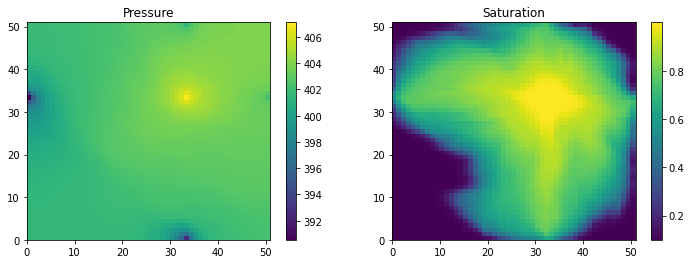

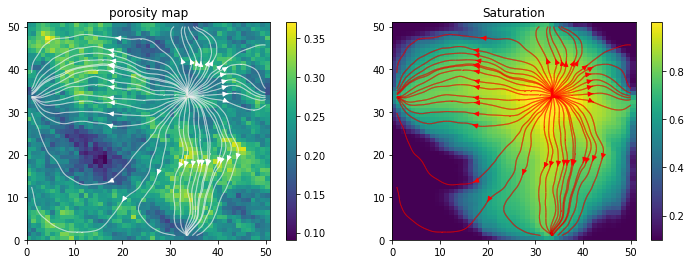

In [43]:
# process active grid
X  = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p  = X[0:2*nb:2] 
z  = X[1:2*nb:2] 

# plot solution
plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.title('Pressure')
plt.colorbar()

# plot solution
plt.subplot(122)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.title('Saturation')
plt.colorbar()
plt.show()

plt.figure(num=1, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,phi,col='w')
plt.colorbar()
plt.title('porosity map')

plt.subplot(122)
m.plot_streamline(p,z,col='r')
plt.title('Saturation')
plt.colorbar()
plt.show()

## task 2

Water breakthrough happens with self.runtime = 10000. When the timer is set to 3 days, by setting the self.runtime to 3, the saturation is not spread through the system yet. This means the system has a lifetime of about 10000 days, which is ~30 years 

## task 3

The streamlines are not changing a lot after time. However, they do concentrate over time in the areas with higher porosity, following the path of least resistance from the injector to the production wells. The 2P map has a diagonal direction of the fluvial system, which leads to a higher concentration of streamlines from NW to SE, assuming the top is north.

In [44]:
%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(m.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()

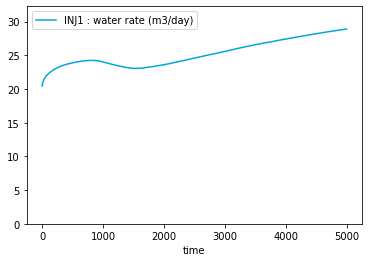

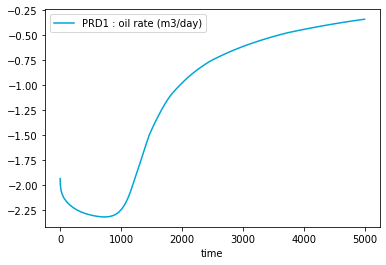

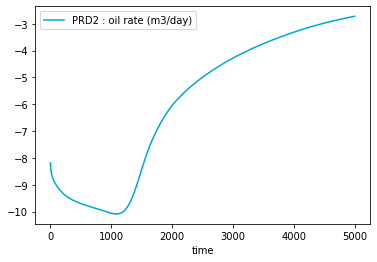

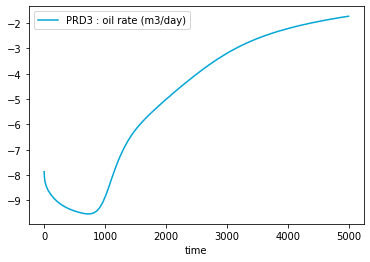

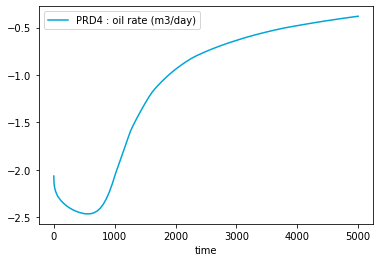

In [45]:
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
plot_water_rate_darts('INJ1', time_data)
plot_oil_rate_darts('PRD1', time_data)
plot_oil_rate_darts('PRD2', time_data)
plot_oil_rate_darts('PRD3', time_data)
plot_oil_rate_darts('PRD4', time_data)
plt.show()